# SciPy Proceedings 2017: "ChiantiPy: A Python Package for Astrophysical Spectroscopy"
This notebook provides the source to build all of the figures for the SciPy 2017 proceedings paper on ChiantiPy.

In [1]:
import os
import glob

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib import ticker
import seaborn.apionly as sns
import pandas as pd
import periodictable
import roman

import ChiantiPy.core as ch
import ChiantiPy.tools.util as ch_util
import ChiantiPy.tools.data as ch_data
import ChiantiPy.tools.io as ch_io

#sns.set_context('paper',
#                rc={prop:plt.rcParams[prop] for prop in ['lines.linewidth','axes.titlesize','axes.labelsize',
#                                                         'xtick.labelsize','ytick.labelsize']})
sns.set_style('white')
sns.set_palette('deep')
%matplotlib inline

/home/wtb2/anaconda3/envs/chiantipy/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


 using cli
 using CLI for selections
 reading chiantirc file


## Database

Make a heatmap showing all of the ions in the CHIANTI database and the associated number of levels. Probably best to build a pandas dataframe first.

In [2]:
ion_list = []
exclude_dirs = ['abundance','ancillary_data','continuum','dem','ioneq','ip','masterlist','VERSION']

In [3]:
for top_dir in glob.glob('/usr/local/ssw/packages/chianti/dbase/*'):
    if os.path.basename(top_dir) not in exclude_dirs:
        for sub_dir in glob.glob(os.path.join(top_dir,'*')):
            ion = os.path.basename(sub_dir)
            if ion[-1] == 'd':
                continue
            elvlc = ch_io.elvlcRead(ion)
            if elvlc['status'] == 0:
                continue
            num_levels = np.max(elvlc['lvl'])
            tmp_name = ch_util.zion2spectroscopic(ch_util.el2z(ion.split('_')[0]),int(ion.split('_')[1]))
            element = list(filter(None,tmp_name.split(' ')))[0]
            stage = list(filter(None,tmp_name.split(' ')))[1]
            ion_list.append({'Element':element,'Stage':stage,'Levels':num_levels})

 elvlc file does not exist:  /usr/local/ssw/packages/chianti/dbase/li/li_4/li_4.elvlc
 elvlc file does not exist:  /usr/local/ssw/packages/chianti/dbase/li/li_1/li_1.elvlc
 elvlc file does not exist:  /usr/local/ssw/packages/chianti/dbase/li/li_2/li_2.elvlc
 elvlc file does not exist:  /usr/local/ssw/packages/chianti/dbase/li/li_3/li_3.elvlc
 elvlc file does not exist:  /usr/local/ssw/packages/chianti/dbase/ti/ti_23/ti_23.elvlc
 elvlc file does not exist:  /usr/local/ssw/packages/chianti/dbase/ti/ti_9/ti_9.elvlc
 elvlc file does not exist:  /usr/local/ssw/packages/chianti/dbase/ti/ti_6/ti_6.elvlc
 elvlc file does not exist:  /usr/local/ssw/packages/chianti/dbase/ti/ti_3/ti_3.elvlc
 elvlc file does not exist:  /usr/local/ssw/packages/chianti/dbase/ti/ti_4/ti_4.elvlc
 elvlc file does not exist:  /usr/local/ssw/packages/chianti/dbase/ti/ti_5/ti_5.elvlc
 elvlc file does not exist:  /usr/local/ssw/packages/chianti/dbase/ti/ti_8/ti_8.elvlc
 elvlc file does not exist:  /usr/local/ssw/packages

In [4]:
ion_table = pd.DataFrame(ion_list)
ion_table_pivot = ion_table.pivot('Element','Stage','Levels')
new_indices = sorted(ion_table_pivot.index, key=lambda x:periodictable.elements.symbol(x).number)
ion_table_pivot = ion_table_pivot.reindex(new_indices)
ion_table_pivot = ion_table_pivot.reindex_axis(sorted(ion_table_pivot.columns.tolist(),key=lambda x:roman.fromRoman(x)),axis=1)

/home/wtb2/anaconda3/envs/chiantipy/lib/python3.5/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


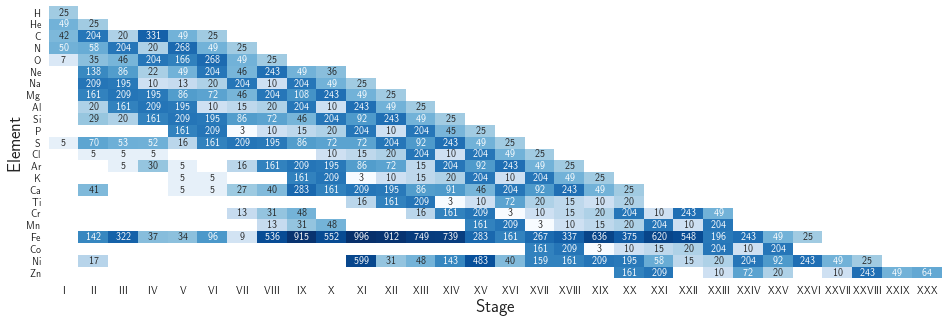

In [5]:
fig = plt.figure(figsize=(16,5))
my_cmap = plt.get_cmap('Blues')
my_cmap.set_bad(color='w')
sns.heatmap(ion_table_pivot,ax=fig.gca(),square=False,cmap=my_cmap,
            annot=True,fmt='.0f',
            norm=matplotlib.colors.LogNorm(vmin=1,vmax=1e3),
            cbar_kws={'ticks':[1,10,100,1000]},
            cbar=False
           )
plt.savefig('figures/linelist.pdf',dpi=1000,format='pdf',bbox_inches='tight')

In [ ]:
def linear_fit(x,a,b):
    return b*x**a

In [ ]:
foo = ch_io.wgfaRead(tmp_ion)
bar = ch_io.elvlcRead(tmp_ion)
delta_energies = np.array(bar['ecm'])[np.array(foo['lvl2'],np.int) - 1] - np.array(bar['ecm'])[np.array(foo['lvl1'],np.int) - 1]
wvl_cm = np.array(foo['wvl'])/1e8
wvl_smooth = np.linspace(wvl_cm.min(),wvl_cm.max(),100)
#delta_energys *= ch_data.
popt,pcov = curve_fit(linear_fit,wvl_cm,delta_energies)
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.plot(wvl_cm,delta_energies,'o',label=tmp_ion,markersize=15,alpha=0.3)
ax.plot(wvl_smooth,linear_fit(wvl_smooth,*popt),'--r')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'$\Delta E$ (cm$^{-1}$)')
ax.set_xlabel(r'Wavelength (cm)')

In [ ]:
spd_ticklabels = sorted(set([(a,b) for a,b in zip(bar['l'],bar['spd'])]),key=lambda x:x[0])

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
for i in range(len(foo['wvl'])):
    l1,e1 = bar['l'][foo['lvl1'][i]-1],bar['eryd'][foo['lvl1'][i]-1]
    l2,e2 = bar['l'][foo['lvl2'][i]-1],bar['eryd'][foo['lvl2'][i]-1]
    ax.scatter(l1,e1,
               marker='_',color=sns.color_palette('deep')[0],s=10)
    ax.scatter(l2,e2,
               marker='_',color=sns.color_palette('deep')[0],s=10)
    ax.annotate(foo['pretty2'][i],
                xy=(l1,e1), xycoords='data',
                xytext=(l2,e2), textcoords='data',
                arrowprops=dict(arrowstyle="-|>",
                                connectionstyle="arc3"),)
    ax.text(l1,e1,foo['pretty1'][i])
ax.set_xticks([x[0] for x in spd_ticklabels])
ax.set_xticklabels([x[1] for x in spd_ticklabels])
#ax.set_ylim([1.3,2])
ax.set_xlabel(r'Orbital')
ax.set_ylabel(r'Energy (Rydbergs)')

## Emissivity and Level Populations

Show plot of populations for a sample ion and a plot of emissivities for a sample ion. These should be as a function of wavelength and temperature/density. We'll probably just use Fe for all of the examples to make things easy.

## Contribution Functions
First, the contribution function function in the ion class needs to be refactored. But then we should show the contribution function for a couple of ions.

## Continuum Emission
Free-free, free-bound, two-photon

In [6]:
wavelength = np.logspace(0,3,100)
temperature = np.logspace(6,8.5,100)
fe18_continuum = ch.Continuum('fe_18',temperature)

### Free-free

In [7]:
fe18_continuum.calculate_free_free_emission(wavelength)

In [8]:
fe18_continuum.calculate_free_bound_emission(wavelength)

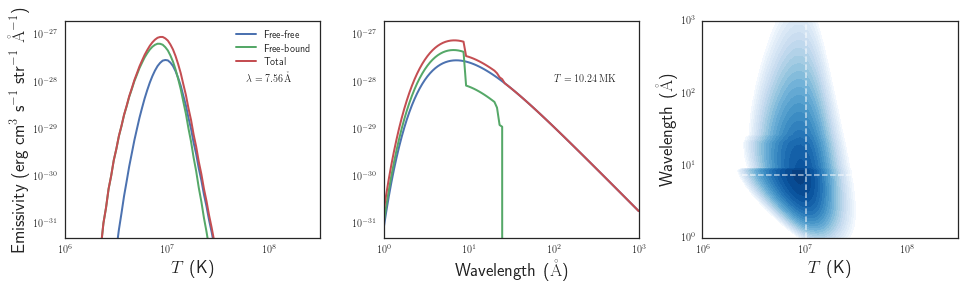

In [9]:
wmesh,tmesh = np.meshgrid(wavelength,temperature)
fig,axes = plt.subplots(1,3,figsize=(16,4))
# Temperature
axes[0].plot(temperature,fe18_continuum.free_free_emission[:,29],label=r'Free-free')
axes[0].plot(temperature,fe18_continuum.free_bound_emission[:,29],label=r'Free-bound')
axes[0].plot(temperature,(fe18_continuum.free_bound_emission[:,29]
                          + fe18_continuum.free_free_emission[:,29]),label=r'Total')
axes[0].text(6e7,1e-28,r'$\lambda={:.2f}\,\mathrm{{\mathring{{A}}}}$'.format(wavelength[29]))
axes[0].legend(loc=1)
axes[0].set_xlabel(r'$T$ (K)')
axes[0].set_ylabel(r'Emissivity (erg cm$^{3}$ s$^{-1}$ str$^{-1}$ $\mathrm{\mathring{A}}^{-1}$)')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_ylim([5e-32,2e-27])
axes[0].set_xlim([temperature[0],temperature[-1]])
# Wavelength
axes[1].plot(wavelength,fe18_continuum.free_free_emission[40,:])
axes[1].plot(wavelength,fe18_continuum.free_bound_emission[40,:])
axes[1].plot(wavelength,(fe18_continuum.free_bound_emission[40,:]
                     + fe18_continuum.free_free_emission[40,:]))
axes[1].text(1e2,1e-28,r'$T={:.2f}\,\mathrm{{MK}}$'.format(temperature[40]/1e6))
axes[1].set_xlabel(r'Wavelength ($\mathrm{\mathring{A}}$)')
#axes[1].set_ylabel(r'Emissivity (erg cm$^{3}$ s$^{-1}$ str$^{-1}$ $\mathrm{\mathring{A}}^{-1}$)')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_ylim([5e-32,2e-27])
axes[1].set_xlim([wavelength[0],wavelength[-1]])
# 2D
custom_cmap = plt.get_cmap('Blues')
custom_cmap.set_bad('w')
im = axes[2].contourf(tmesh,wmesh,
               fe18_continuum.free_free_emission+fe18_continuum.free_bound_emission,
               cmap=custom_cmap,
                     norm=matplotlib.colors.LogNorm(vmin=5e-32,vmax=2e-27),
                     #locator=ticker.LogLocator(),
                     levels=np.logspace(np.log10(5e-32),np.log10(2e-27),25),
                    )
axes[2].axvline(x=temperature[40],ls='--',color='w',alpha=0.5,lw=2.)
axes[2].axhline(y=wavelength[29],ls='--',color='w',alpha=0.5,lw=2.)
axes[2].set_xlabel(r'$T$ (K)')
axes[2].set_ylabel(r'Wavelength ($\mathrm{\mathring{A}}$)')
axes[2].set_xscale('log')
axes[2].set_yscale('log')
#fig.colorbar(im,ax=axes[2])
#plt.tight_layout()
plt.subplots_adjust(wspace=0.25)
plt.savefig('figures/continuum.pdf',dpi=1000,format='pdf',bbox_inches='tight')

## Ionization Equilibrium
Include some equations that describe the ionization equilibrium.

First figure shows a comparison between the loaded data of the latest CHIANTI ionization equilibrium file and an older Mazzotta file. This figure may not be used at all.

In [26]:
fe_ioneq_chianti = ch.ioneq('Fe')
fe_ioneq_chianti.load()
fe_ioneq_mazzotta = ch.ioneq('Fe')
fe_ioneq_mazzotta.load(ioneqName='mazzotta_etal')

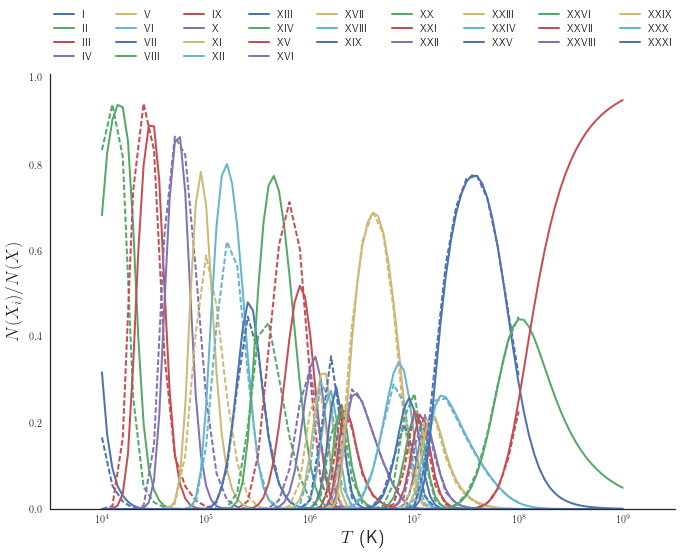

In [30]:
fig = plt.figure(figsize=(11.2,8))
ax = fig.gca()
colors = sns.color_palette(n_colors=fe_ioneq_chianti.Ioneq.shape[0])
for i in range(fe_ioneq_chianti.Ioneq.shape[0]):
    ax.plot(fe_ioneq_chianti.Temperature,fe_ioneq_chianti.Ioneq[i,:],
            label=roman.toRoman(i+1),
            color=colors[i]
           )
    ax.plot(fe_ioneq_mazzotta.Temperature,fe_ioneq_mazzotta.Ioneq[i,:],
            color=colors[i],
            ls='--'
           )
    
ax.set_xscale('log')
ax.set_ylim([0,1.01])
ax.set_xlabel(r'$T$ (K)')
ax.set_ylabel(r'$N(X_i)/N(X)$')
ax.set_xlim([temperature[0],temperature[-1]])
ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=9)
sns.despine(fig=fig,ax=ax)

This second figure shows the ionization equilibrium calculated over a custom temperature range for four different elements.

In [20]:
els = ['H','Na','S','Fe']
temperature = np.logspace(3.5,9.5,500)
ioneqs = {el:{'calc':{'temperature':temperature},'data':{}} for el in els}
for el in els:
    tmp_ioneq = ch.ioneq(el)
    tmp_ioneq.calculate(temperature)
    ioneqs[el]['calc']['ioneq'] = tmp_ioneq.Ioneq
    tmp_ioneq_data = ch.ioneq(el)
    tmp_ioneq_data.load(ioneqName='mazzotta_etal')
    ioneqs[el]['data']['temperature'] = tmp_ioneq_data.Temperature
    ioneqs[el]['data']['ioneq'] = tmp_ioneq_data.Ioneq

 Z     1 Stage     1  ionStr h_1
 Z     1 Stage     2  ionStr h_2


/home/wtb2/anaconda3/envs/chiantipy/lib/python3.5/site-packages/ChiantiPy-0.7.dev500-py3.5.egg/ChiantiPy/core/Ioneq.py:99: RuntimeWarning: divide by zero encountered in double_scalars
  rat = anIon.IonizRate['rate'][it]/anIon.RecombRate['rate'][it]
/home/wtb2/anaconda3/envs/chiantipy/lib/python3.5/site-packages/ChiantiPy-0.7.dev500-py3.5.egg/ChiantiPy/core/Ioneq.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  factor.append(rat**2 + rat**(-2))


 Z    11 Stage     1  ionStr na_1
 Z    11 Stage     2  ionStr na_2
 Z    11 Stage     3  ionStr na_3
 Z    11 Stage     4  ionStr na_4
 Z    11 Stage     5  ionStr na_5
 Z    11 Stage     6  ionStr na_6
 Z    11 Stage     7  ionStr na_7
 Z    11 Stage     8  ionStr na_8
 Z    11 Stage     9  ionStr na_9
 Z    11 Stage    10  ionStr na_10
 Z    11 Stage    11  ionStr na_11
 Z    11 Stage    12  ionStr na_12
 Z    16 Stage     1  ionStr s_1
 Z    16 Stage     2  ionStr s_2
 Z    16 Stage     3  ionStr s_3
 Z    16 Stage     4  ionStr s_4
 Z    16 Stage     5  ionStr s_5
 Z    16 Stage     6  ionStr s_6
 Z    16 Stage     7  ionStr s_7
 Z    16 Stage     8  ionStr s_8
 Z    16 Stage     9  ionStr s_9
 Z    16 Stage    10  ionStr s_10
 Z    16 Stage    11  ionStr s_11
 Z    16 Stage    12  ionStr s_12
 Z    16 Stage    13  ionStr s_13
 Z    16 Stage    14  ionStr s_14
 Z    16 Stage    15  ionStr s_15
 Z    16 Stage    16  ionStr s_16
 Z    16 Stage    17  ionStr s_17
 Z    26 Stage     1

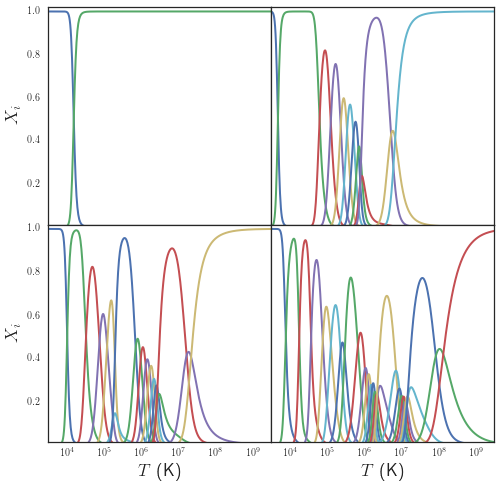

In [25]:
fig,axes = plt.subplots(2,2,figsize=(8,8),sharex=True,sharey=True)
for ax,el in zip(axes.flatten(),els):
    colors = sns.color_palette(n_colors=ioneqs[el]['calc']['ioneq'].shape[0])
    for i in range(ioneqs[el]['calc']['ioneq'].shape[0]):
        ax.plot(ioneqs[el]['calc']['temperature'],ioneqs[el]['calc']['ioneq'][i,:],color=colors[i],ls='-')
        #ax.plot(ioneqs[el]['data']['temperature'],ioneqs[el]['data']['ioneq'][i,:],color=colors[i],ls='--')
    ax.set_xscale('log')
    ax.set_ylim([0.01,1.02])
    ax.set_xlim([temperature[0],temperature[-1]])
    if axes.flatten().tolist().index(ax) > 1:
        ax.set_xlabel(r'$T$ (K)')
    if axes.flatten().tolist().index(ax)%2 == 0:
        ax.set_ylabel(r'$X_i$')
plt.subplots_adjust(hspace=0,wspace=0)
plt.savefig('figures/ioneq.pdf',dpi=1000,format='pdf',bbox_inches='tight')

## Radiative Losses

## Spectra